In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
import torch
from scipy.special import softmax 
from sklearn.preprocessing import StandardScaler

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.infer import Predictive
from sklearn.model_selection import train_test_split

from models import model__prior_mu_studentT as model 
from collections import Counter
from pyro.infer import MCMC, NUTS

### Data Processing

In [2]:
scaler = StandardScaler()
df = pd.read_pickle('../pickle/df.pkl')

In [3]:
df_sampled = df.sample(1400,random_state=47)

In [4]:
df_features = df_sampled.iloc[:,:-1].copy()
df_target = df_sampled.iloc[:,-1].copy()

In [5]:
df_features = scaler.fit_transform(df_features)

In [6]:
df_train_features, df_test_features,df_train_target, df_test_target =  train_test_split(df_features,df_target,stratify=df_target,random_state=47, test_size=1/7)

df_train_features, df_val_features,df_train_target, df_val_target =  train_test_split(df_train_features,df_train_target,stratify=df_train_target,random_state=47, test_size=1/6)

In [7]:
df_train_target = df_train_target.to_numpy()
df_test_target = df_test_target.to_numpy()
df_val_target = df_val_target.to_numpy()

In [8]:
D = df_train_features.shape[1]
N_train = df_train_features.shape[0]
N_test = df_test_features.shape[0]
N_val = df_val_features.shape[0]
n_cat = 11 
degF=4
tau=1

### Ancestral Sampling 

In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [10]:
# sample coefficients (beta)
beta = np.random.normal(0,1,size=D)
print("beta:", beta)

beta_array = np.zeros((n_cat,D))

for i in range(n_cat):
    
    beta_array[i,:] = np.random.normal(0,1,size=D)
    
# sample observations (y's)
y = np.zeros((N_train,n_cat))
for n in range(N_train):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([(np.dot(beta_array[i,:], df_train_features[n,:]))])
        
    p =  softmax(probs)
    y[n,:] = np.random.multinomial(1, p)  #binomial with one trial is equivalent to bernoulli

beta: [-1.39222823 -2.26461216  0.17465402  1.09754213 -0.72093459  0.31313922
  0.6397472   3.27773434 -0.06842263  1.6236427   0.50601562  1.44883915
 -0.25316098 -0.76911183]


In [11]:
label_array = np.array([]) 
for i in y:
    label_array = np.append(label_array,np.argmax(i))

In [12]:
counts = Counter(label_array)

In [13]:
print("Accuracy:", 1.0*np.sum(label_array == df_train_target.flatten()) / len(df_train_target))

Accuracy: 0.103


In [14]:
X_train = torch.tensor(df_train_features).float()
y_train = torch.tensor(df_train_target.flatten()).float()

#### Model training 

In [15]:
degF=4
tau=1

In [21]:
# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=500, num_chains=4)
mcmc.run(X_train, n_cat, degF, tau, y_train)

# Show summary of inference results
mcmc.summary()


Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/2500 [00:00, ?it/s]


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
    alpha[0,0]     -3.97      2.07     -3.95     -7.18     -0.51   1156.04      1.01
    alpha[0,1]      3.21      1.61      3.19      0.52      5.80    768.80      1.01
    alpha[0,2]      2.35      1.61      2.33     -0.36      4.93    786.47      1.01
    alpha[0,3]     -4.64      2.30     -4.56     -8.20     -0.68    639.55      1.01
    alpha[0,4]     -2.23      1.99     -2.21     -5.59      0.90    819.02      1.01
    alpha[0,5]      1.70      1.62      1.69     -1.09      4.28    800.32      1.01
    alpha[0,6]      3.94      1.61      3.92      1.25      6.55    772.69      1.01
    alpha[0,7]     -9.62      3.07     -9.49    -14.56     -4.67   1322.21      1.00
    alpha[0,8]      1.47      1.65      1.46     -1.33      4.10    764.74      1.01
    alpha[0,9]      3.52      1.61      3.49      0.85      6.17    769.42      1.01
   alpha[0,10]      4.25      1.60      4.24      1.58      6.87

In [22]:
posterior_samples = mcmc.get_samples()

samples_alpha = posterior_samples['alpha'].detach().squeeze()
samples_beta = posterior_samples['beta'].detach().squeeze()

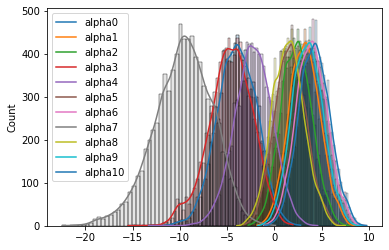

In [23]:
for c in range(n_cat):
    sns.histplot(samples_alpha[:,c], kde=True, alpha=0.2)
plt.legend(["alpha%d" % c for c in range(n_cat)])
plt.show()

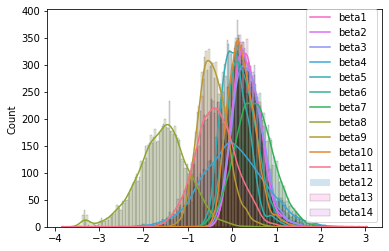

In [24]:
for c in range(1):
    sns.histplot(samples_beta[:,c], kde=True, alpha=0.2)
plt.legend(["beta%d" % int(int(c)+1) for c in range(D)])
plt.show()

### Inference and computation of accuracy on the train dataset 

In [25]:
mean_betas = samples_beta.mean(axis=0)
mean_betas = mean_betas.T
mean_alpha = samples_alpha.mean(axis=0)
mean_alpha = mean_alpha.T

    
y_train_pred = np.zeros((N_train,n_cat))

for n in range(N_train):

    probs = np.zeros(n_cat)
    
    for i in range(n_cat):
        probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_train_features[n,:]))])

    p =  softmax(probs)
    y_train_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli

y_train_pred = y_train_pred[:,0]


print("Train Accuracy:", 1.0*np.sum(y_train_pred == df_train_target.flatten()) / len(y_train_pred))

Train Accuracy: 0.508


### Inference and computation of accuracy on the test dataset 

In [26]:
y_test_pred = np.zeros((N_test,n_cat))

for n in range(N_test):

    probs = np.zeros(n_cat)
    
    for i in range(n_cat):
        probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_test_features[n,:]))])

    p =  softmax(probs)
    y_test_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli

y_test_pred = y_test_pred[:,0]


print("Test Accuracy:", 1.0*np.sum(y_test_pred == df_test_target.flatten()) / len(y_test_pred))

Test Accuracy: 0.47
